In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import datetime
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
sns.set(style='whitegrid',palette='tab10')
matplotlib.rcParams['font.sans-serif'] = ['SimHei']

### 数据读取、展示、缺失值处理

In [137]:
train=pd.read_csv('./train.csv',encoding='utf-8')
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [138]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [139]:
test=pd.read_csv('./test.csv',encoding='utf-8')
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


In [140]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


通过查看训练集与测试集的详细信息发现都没有缺失值

### 数据处理

#### 异常值处理

In [141]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


可以看出租赁额（count）数值差异大，再观察一下它们的密度分布：

[Text(0.5, 0, 'count'), Text(0.5, 1.0, '租用数量密度分布')]

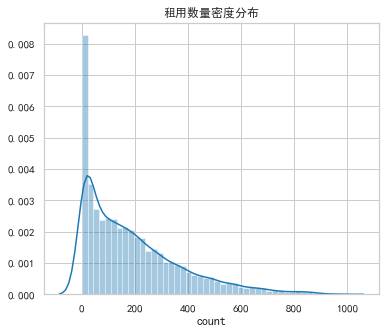

In [142]:
#观察租赁额密度分布
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_size_inches(6,5)

sns.distplot(train['count'])
ax.set(xlabel='count',title='租用数量密度分布')


In [143]:
train_WithoutOutliers=train[np.abs(train['count']-train['count'].mean())<=(3*train['count'].std())]
print(train_WithoutOutliers.shape)
train_WithoutOutliers['count'].describe()

(10739, 12)


count    10739.000000
mean       183.003818
std        166.681429
min          1.000000
25%         41.000000
50%        141.000000
75%        276.000000
max        734.000000
Name: count, dtype: float64

[Text(0.5, 0, 'registered'), Text(0.5, 1.0, 'count的分布')]

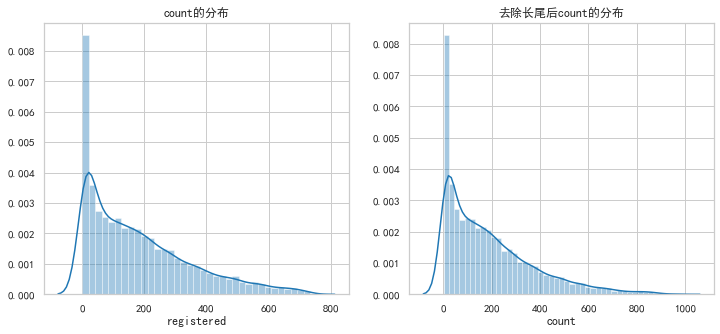

In [144]:
fig=plt.figure(figsize=(12,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)


sns.distplot(train_WithoutOutliers['count'],ax=ax1)
sns.distplot(train['count'],ax=ax2)
ax2.set(xlabel='count',title='去除长尾后count的分布')
ax1.set(xlabel='registered',title='count的分布')

数据波动依然很大，而我们希望波动相对稳定，否则容易产生过拟合，所以希望对数据进行处理，使得数据相对稳定，此处选择对数变化，来使得数据稳定。

f:\python3.8\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
f:\python3.8\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


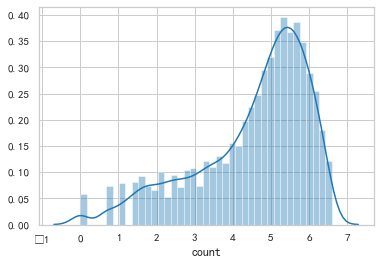

In [145]:
yLabels=train_WithoutOutliers['count']
yLabels_log=np.log(yLabels)
sns.distplot(yLabels_log)

经过对数变换后数据分布更均匀，大小差异也缩小了，使用这样的标签对训练模型是有效果的。接下来对其余的数值型数据进行处理，由于其他数据同时包含在两个数据集中，为方便数据处理先将两个数据集合并。

In [146]:
test['casual']=-1
test['registered']=-1
test['count']=-1

In [147]:
Bike_data=pd.concat([train_WithoutOutliers,test],ignore_index=True)
Bike_data.shape

(17232, 12)

[Text(0.5, 0, 'windspeed'), Text(0.5, 1.0, '风速分布情况')]

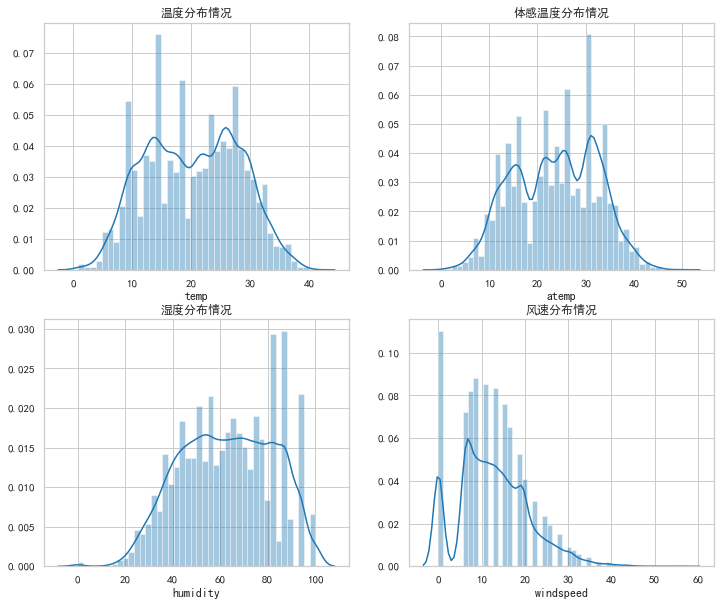

In [148]:
fig,axes=plt.subplots(2,2)
fig.set_size_inches(12,10)

sns.distplot(Bike_data['temp'],ax=axes[0,0])
sns.distplot(Bike_data['atemp'],ax=axes[0,1])
sns.distplot(Bike_data['humidity'],ax=axes[1,0])
sns.distplot(Bike_data['windspeed'],ax=axes[1,1])

axes[0,0].set(xlabel='temp',title='温度分布情况')
axes[0,1].set(xlabel='atemp',title='体感温度分布情况')
axes[1,0].set(xlabel='humidity',title='湿度分布情况')
axes[1,1].set(xlabel='windspeed',title='风速分布情况')

通过观察分布，发现风速为0的数据很多，但通过前边的观察统计可知整体数据是不包含缺失值的，所以可以推测到，数据本身应该是有缺失的，但是用0填充了，这些风速为0的数据会对预测产生干扰，可以使用随机森林根据相同的年份，月份，季节，温度，湿度等几个特征填充下风速的缺失值。

In [149]:
#风速不为0的数据的风速的统计描述
Bike_data[Bike_data['windspeed']!=0]['windspeed'].describe()

count    15068.000000
mean        14.556762
std          7.092624
min          6.003200
25%          8.998100
50%         12.998000
75%         19.001200
max         56.996900
Name: windspeed, dtype: float64

In [150]:
from sklearn.ensemble import RandomForestRegressor

Bike_data["windspeed_rfr"]=Bike_data["windspeed"]
# 将数据分成风速等于0和不等于两部分 
dataWind0 = Bike_data[Bike_data["windspeed_rfr"]==0]
dataWind0['year']=pd.DatetimeIndex(dataWind0['datetime']).year
dataWind0['month']=pd.DatetimeIndex(dataWind0['datetime']).month
dataWindNot0 = Bike_data[Bike_data["windspeed_rfr"]!=0]
dataWindNot0['year']=pd.DatetimeIndex(dataWindNot0['datetime']).year
dataWindNot0['month']=pd.DatetimeIndex(dataWindNot0['datetime']).month
#选定模型
rfModel_wind = RandomForestRegressor(n_estimators=1000,random_state=42)
# 选定特征值
windColumns = ["season","weather","humidity","month","temp","year","atemp"]
# 将风速不等于0的数据作为训练集，fit到RandomForestRegressor之中
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed_rfr"])
# 通过训练好的模型预测风速
wind0Values = rfModel_wind.predict(X= dataWind0[windColumns])
#将预测的风速填充到风速为零的数据中
dataWind0.loc[:,"windspeed_rfr"] = wind0Values
#连接两部分数据
Bike_data = dataWindNot0.append(dataWind0)
Bike_data.reset_index(inplace=True)
Bike_data.drop('index',inplace=True,axis=1)


<ipython-input-150-c6dd11b40c67>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataWind0['year']=pd.DatetimeIndex(dataWind0['datetime']).year
<ipython-input-150-c6dd11b40c67>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataWind0['month']=pd.DatetimeIndex(dataWind0['datetime']).month
<ipython-input-150-c6dd11b40c67>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

[Text(0.5, 0, 'windseed'), Text(0.5, 1.0, '风速分布情况')]

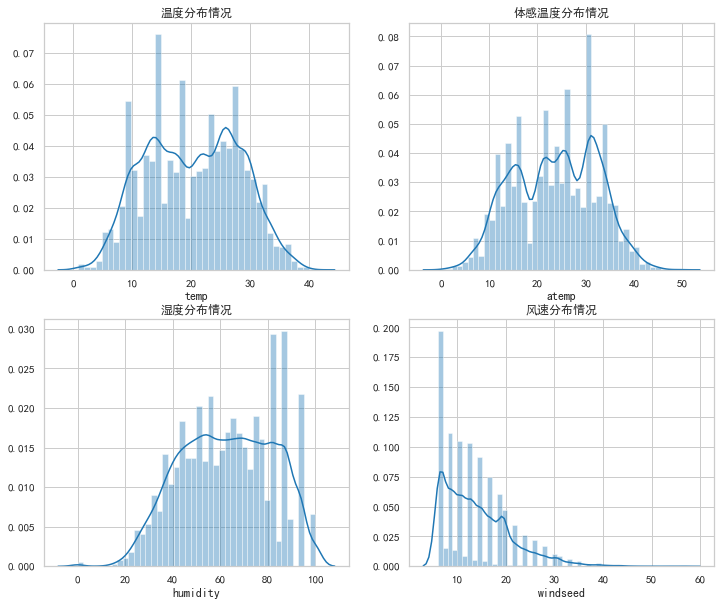

In [151]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(12,10)

sns.distplot(Bike_data['temp'],ax=axes[0,0])
sns.distplot(Bike_data['atemp'],ax=axes[0,1])
sns.distplot(Bike_data['humidity'],ax=axes[1,0])
sns.distplot(Bike_data['windspeed_rfr'],ax=axes[1,1])

axes[0,0].set(xlabel='temp',title='温度分布情况')
axes[0,1].set(xlabel='atemp',title='体感温度分布情况')
axes[1,0].set(xlabel='humidity',title='湿度分布情况')
axes[1,1].set(xlabel='windseed',title='风速分布情况')

####  时间型数处理

In [152]:
Bike_data['date']=pd.DatetimeIndex(Bike_data['datetime']).date
Bike_data['hour']=pd.DatetimeIndex(Bike_data['datetime']).hour
Bike_data['year']=pd.DatetimeIndex(Bike_data['datetime']).year
Bike_data['month']=pd.DatetimeIndex(Bike_data['datetime']).month
Bike_data['weekday']=pd.DatetimeIndex(Bike_data['datetime']).weekday
Bike_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,windspeed_rfr,year,month,date,hour,weekday
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,6.003200,2011,1,2011-01-01,5,5
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,16.997900,2011,1,2011-01-01,10,5
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,19.001200,2011,1,2011-01-01,11,5
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,55,84,19.001200,2011,1,2011-01-01,12,5
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,47,94,19.999500,2011,1,2011-01-01,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17227,2012-12-29 12:00:00,1,0,0,3,8.20,12.120,100,0.0000,-1,-1,-1,9.573772,2012,12,2012-12-29,12,5
17228,2012-12-29 13:00:00,1,0,0,3,8.20,12.120,100,0.0000,-1,-1,-1,9.573772,2012,12,2012-12-29,13,5
17229,2012-12-29 15:00:00,1,0,0,2,9.84,12.120,87,0.0000,-1,-1,-1,7.449305,2012,12,2012-12-29,15,5
17230,2012-12-29 23:00:00,1,0,0,2,10.66,12.120,60,0.0000,-1,-1,-1,25.859701,2012,12,2012-12-29,23,5


### 数据分析

####  描述性分析

In [153]:
Bike_data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,17232.0,2.498085,1.108630,1.0000,2.0000,3.000,3.0000,4.0000
holiday,17232.0,0.029016,0.167856,0.0000,0.0000,0.000,0.0000,1.0000
workingday,17232.0,0.680188,0.466417,0.0000,0.0000,1.000,1.0000,1.0000
weather,17232.0,1.426764,0.640080,1.0000,1.0000,1.000,2.0000,4.0000
temp,17232.0,20.315176,7.888360,0.8200,13.9400,20.500,27.0600,41.0000
atemp,17232.0,23.723688,8.587677,0.0000,16.6650,24.240,31.0600,50.0000
humidity,17232.0,62.831708,19.286670,0.0000,48.0000,63.000,79.0000,100.0000
windspeed,17232.0,12.728719,8.201072,0.0000,7.0015,12.998,16.9979,56.9969
casual,17232.0,21.572365,42.870930,-1.0000,-1.0000,2.000,25.0000,367.0000
registered,17232.0,91.722203,129.567279,-1.0000,-1.0000,22.000,151.2500,712.0000


温度, 体表温度, 相对湿度, 风速均近似对称分布, 而非注册用户, 注册用户,以及总数均右边分布。

In [154]:
for i in range(5, 12):
    name = train.columns[i]
    print('{0}偏态系数为 {1}, 峰态系数为 {2}'.format(name, train[name].skew(), train[name].kurt()))

temp偏态系数为 0.003690844422472008, 峰态系数为 -0.9145302637630794
atemp偏态系数为 -0.10255951346908665, 峰态系数为 -0.8500756471754651
humidity偏态系数为 -0.08633518364548581, 峰态系数为 -0.7598175375208864
windspeed偏态系数为 0.5887665265853944, 峰态系数为 0.6301328693364932
casual偏态系数为 2.4957483979812567, 峰态系数为 7.551629305632764
registered偏态系数为 1.5248045868182296, 峰态系数为 2.6260809999210672
count偏态系数为 1.2420662117180776, 峰态系数为 1.3000929518398334


temp, atemp, humidity低度偏态, windspeed中度偏态, casual, registered, count高度偏态；
temp, atemp, humidity为平峰分布, windspeed,casual, registered, count为尖峰分布。

#### 探索性分析

##### 整体性分析

In [155]:
n_Bike_data=Bike_data.loc[(Bike_data['casual']!=-1)&(Bike_data['registered']!=-1)&(Bike_data['count']!=-1)]
n_Bike_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,windspeed_rfr,year,month,date,hour,weekday
0,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,6.003200,2011,1,2011-01-01,5,5
1,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12,24,36,16.997900,2011,1,2011-01-01,10,5
2,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26,30,56,19.001200,2011,1,2011-01-01,11,5
3,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29,55,84,19.001200,2011,1,2011-01-01,12,5
4,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47,47,94,19.999500,2011,1,2011-01-01,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16360,2012-12-17 12:00:00,4,0,1,2,16.40,20.455,87,0.0000,21,211,232,10.695380,2012,12,2012-12-17,12,0
16361,2012-12-17 15:00:00,4,0,1,2,17.22,21.210,88,0.0000,15,196,211,9.949964,2012,12,2012-12-17,15,0
16362,2012-12-18 08:00:00,4,0,1,1,15.58,19.695,94,0.0000,10,652,662,7.285353,2012,12,2012-12-18,8,1
16363,2012-12-18 22:00:00,4,0,1,1,13.94,16.665,49,0.0000,5,127,132,12.183761,2012,12,2012-12-18,22,1


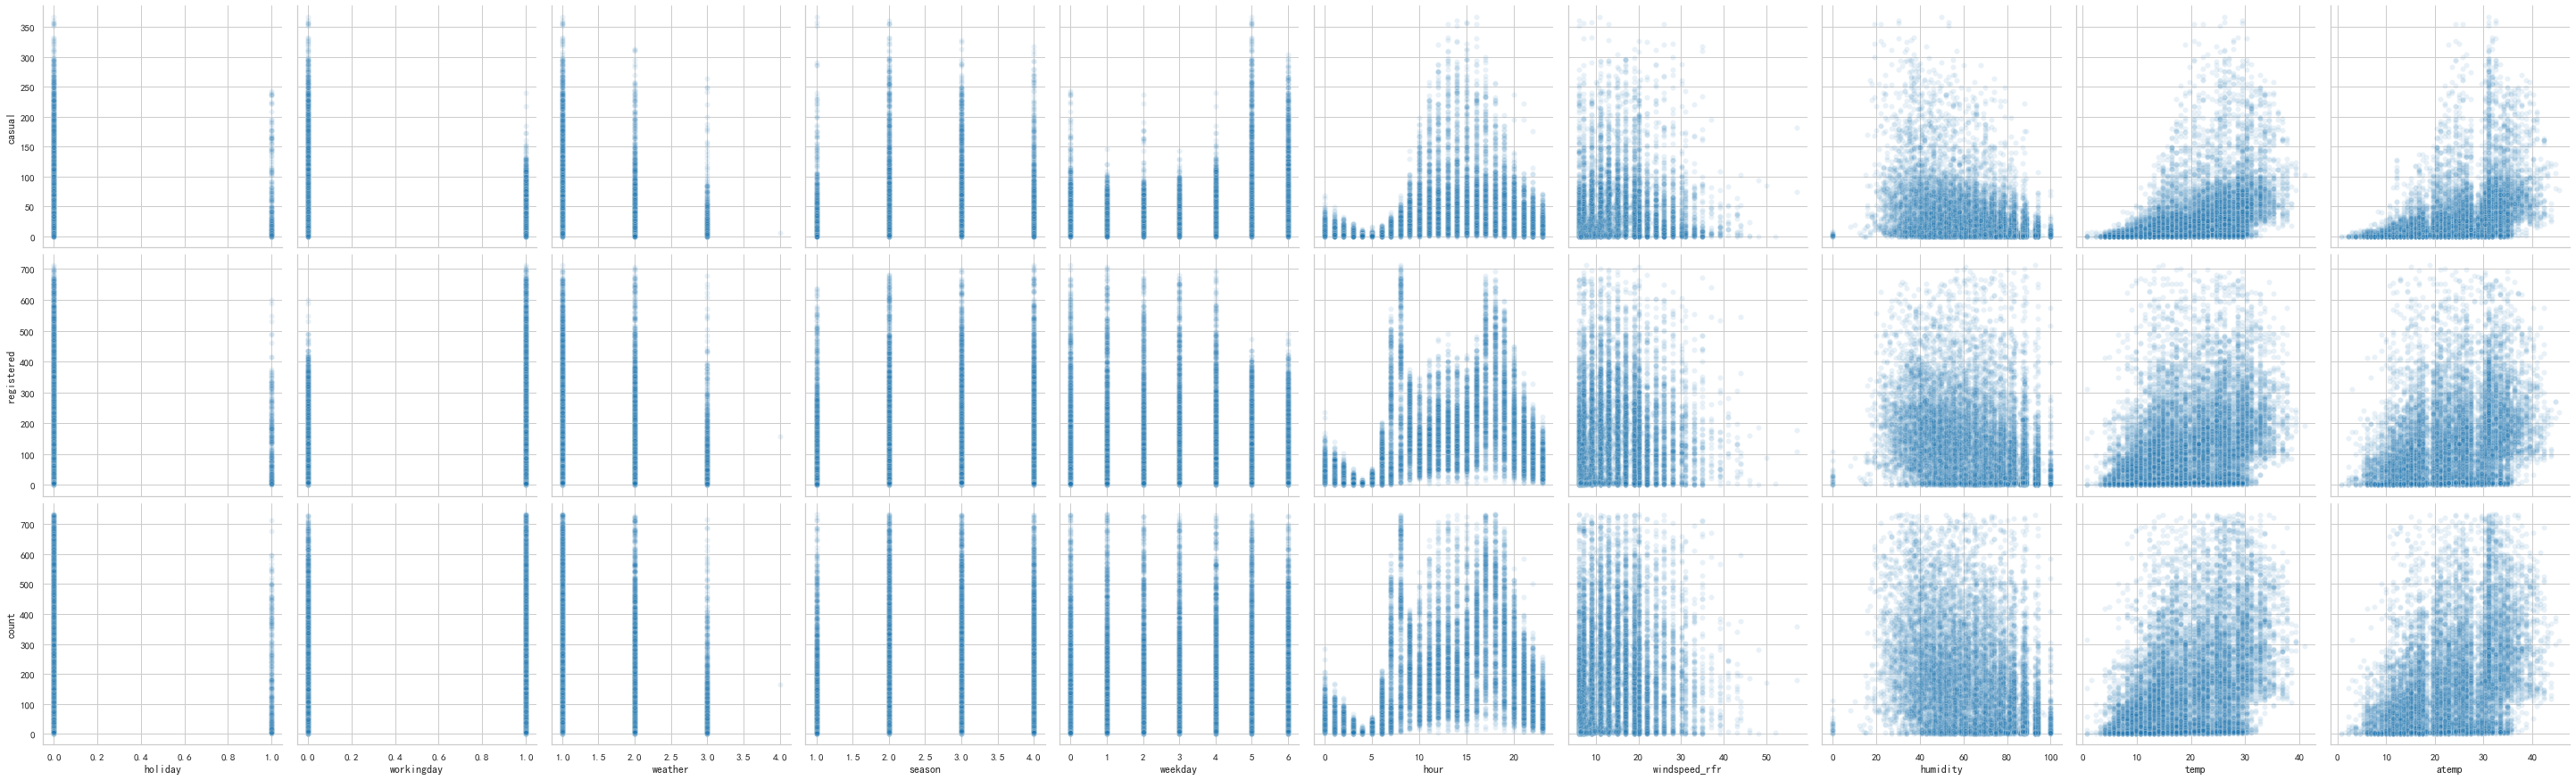

In [156]:

sns.pairplot(n_Bike_data ,
             height=4,
             x_vars=['holiday','workingday','weather','season',
                                'weekday','hour','windspeed_rfr','humidity','temp','atemp'] ,
             y_vars=['casual','registered','count'] , plot_kws={'alpha': 0.1})


大致可以看出：

1. 会员在工作日出行多，节假日出行少，临时用户则相反；
2. 一季度出行人数总体偏少；
3. 租赁数量随天气等级上升而减少；
4. 小时数对租赁情况影响明显，会员呈现两个高峰，非会员呈现一个正态分布；
5. 租赁数量随风速增大而减少；
6. 温度、湿度对非会员影响比较大，对会员影响较小。

##### 相关性分析

各个特征与每小时租车总量（count）的相关性

f:\python3.8\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
f:\python3.8\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


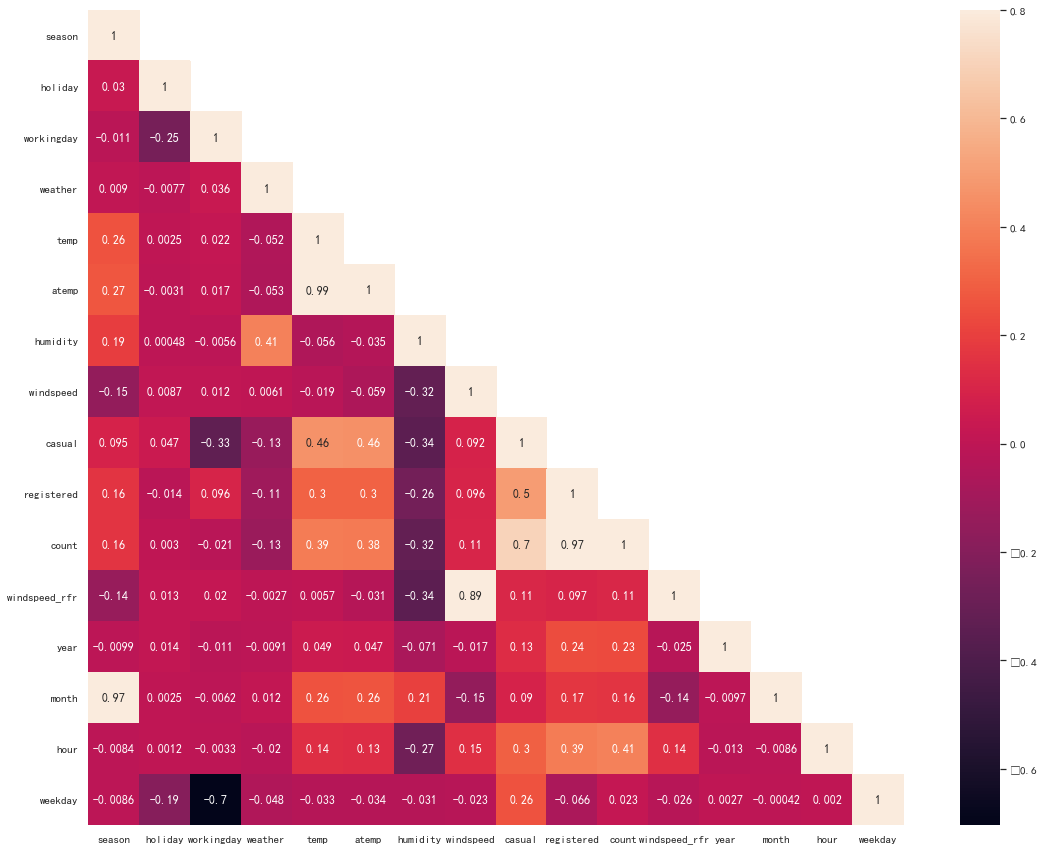

In [157]:
correlation = n_Bike_data.corr()
mask = np.array(correlation)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,15)
sns.heatmap(correlation, mask=mask,vmax=.8, square=True,annot=True)

plt.show()

count 和 registered、casual高度正相关，相关系数分别为0.7 与0.97。因为 count = casual + registered ，所以这个正相关和预期相符。count 和 temp 正相关，相关系数为 0.39。一般来说，气温过低人们不愿意骑车出行。count 和 humidity（湿度）负相关，湿度过大的天气不适宜骑车。当然考虑湿度的同时也应该考虑温度。windspeed似乎对租车人数影响不大（0.1），但我们也应该考虑到极端大风天气出现频率应该不高。风速在正常范围内波动应该对人们租车影响不大。可以看出特征值对租赁数量的影响力度为,时段>温度>湿度>年份>月份>季节>天气等级>风速>星期几>是否工作日>是否假日

##### 影响因素分析

###### 时段对租赁数量的影响

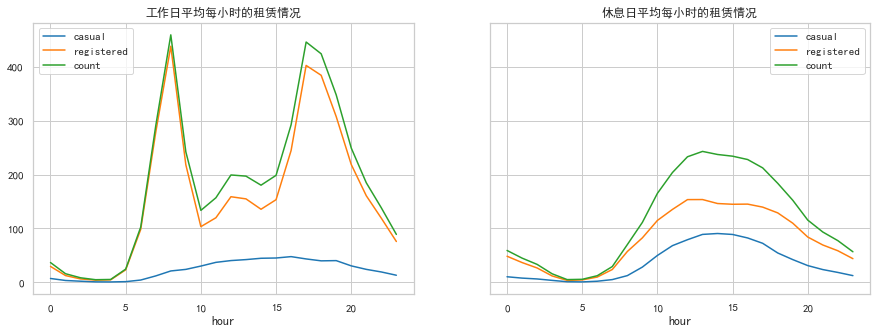

In [158]:
workingday_df=n_Bike_data[n_Bike_data['workingday']==1]
workingday_df = workingday_df.groupby(['hour'], as_index=True).agg({'casual':'mean',
                                                                    'registered':'mean',
                                                                    'count':'mean'})

nworkingday_df=Bike_data[Bike_data['workingday']==0]
nworkingday_df = nworkingday_df.groupby(['hour'], as_index=True).agg({'casual':'mean',
                                                                      'registered':'mean', 
                                                                      'count':'mean'})
fig, axes = plt.subplots(1, 2,sharey = True)

workingday_df.plot(figsize=(15,5),title = '工作日平均每小时的租赁情况',ax=axes[0])
nworkingday_df.plot(figsize=(15,5),title = '休息日平均每小时的租赁情况',ax=axes[1])

通过观察上述两个图可以看到
·工作日：
1. 对于会员用户来说两个用车高峰为早7 8点左右，晚5 6点左右，这段时间一般是上下班时间，中午的时候也会有个小高峰，可能是中午外出就餐。
2. 对于非会员用户来说用户欺负比较平缓，高峰期在17点左右，可能是出去买菜或者吃饭。
3. 通过以上观察可以发现，会员用户的用车数量远超过非会员用户
·非工作日
1. 租赁数量随着一天之内时间的变化呈现一个正态分布，用车最多时间在14点左右，最低在4点左右

###### 温度对租赁数量的影响

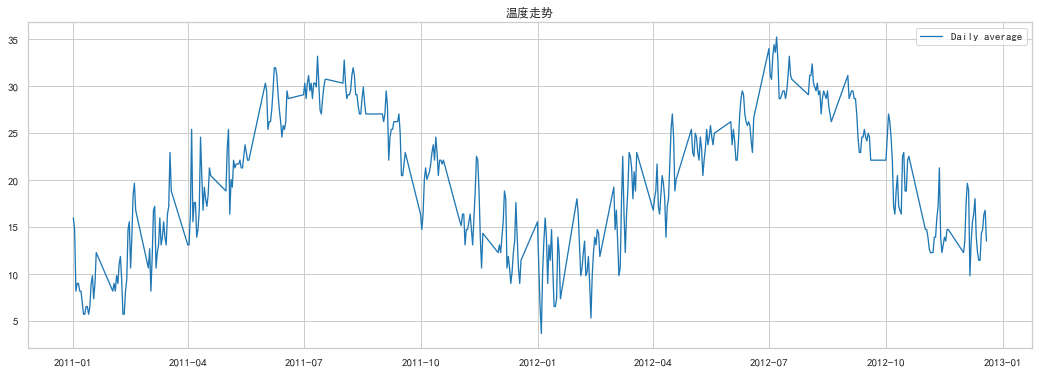

In [159]:
#数据按小时统计展示起来太麻烦，希望能够按天汇总取一天的气温中位数
temp_df = n_Bike_data.groupby(['date','weekday'], as_index=False).agg({'year':'mean',
                                                                     'month':'mean',
                                                                     'temp':'median'})
                                                                     
#预计按天统计的波动仍然很大，再按月取日平均值
temp_month = temp_df.groupby(['year','month'], as_index=False).agg({'weekday':'min',
                                                                    'temp':'median'})
#将按天求和统计数据的日期转换成datetime格式
temp_df['date']=pd.to_datetime(temp_df['date'])
                                                                  
#设置画框尺寸
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,1,1)

#使用折线图展示总体租赁情况（count）随时间的走势
plt.plot(temp_df['date'] , temp_df['temp'] , linewidth=1.3 , label='Daily average')
ax.set_title('温度走势')

ax.legend()                                                                  

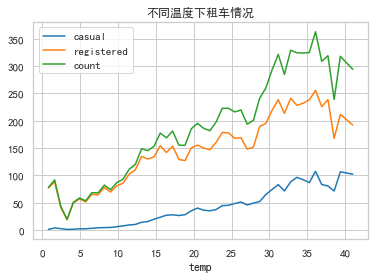

In [160]:
temp_rentals = n_Bike_data.groupby(['temp'], as_index=True).agg({'casual':'mean',
                                                                       'registered':'mean',
                                                                       'count':'mean'})
temp_rentals .plot (title = '不同温度下租车情况')

###### 湿度对租赁数量的影响

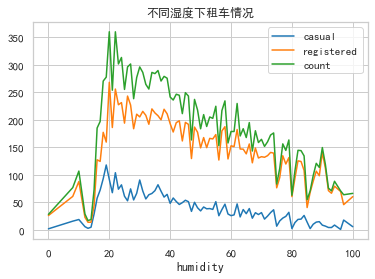

In [161]:
humidity_rentals = n_Bike_data.groupby(['humidity'], as_index=True).agg({'casual':'mean',
                                                                       'registered':'mean',
                                                                       'count':'mean'})
humidity_rentals .plot (title = '不同湿度下租车情况')

###### 年份、月份对租赁数量的影响

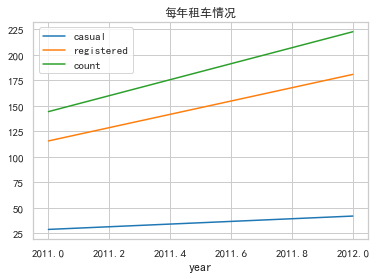

In [162]:
year_rentals = n_Bike_data.groupby(['year'], as_index=True).agg({'casual':'mean',
                                                                       'registered':'mean',
                                                                       'count':'mean'})
year_rentals .plot (title = '每年租车情况')

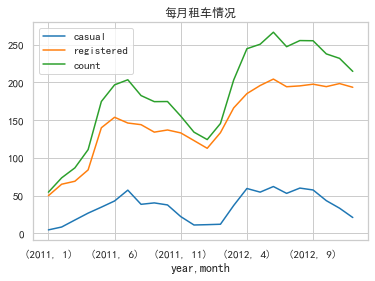

In [163]:
month_rentals = n_Bike_data.groupby(['year','month'], as_index=True).agg({'casual':'mean',
                                                                       'registered':'mean',
                                                                       'count':'mean'})
month_rentals .plot (title = '每月租车情况')

通过观察以上两个图可以发现：
1. 共享单车整体租赁情况2011到2012是有所增长的
2. 在每年1月份租车数量达到全年最低，7 8月达到全年最高
3. 上半年租车数量逐渐提高，下半年租车数量逐渐降低
4. 通过前边的温度变化情况可推测出来，上半年租车数量逐渐提高，下半年租车数量逐渐降低可能是因为温度的原因，上半年温度逐渐升高，华盛顿不会感觉那么冷，适合骑单车，下半年温度逐渐降低，不适合骑单车，所以呈现如图所示变化趋势
5. 12-次年一月份租车数量最低，推测一方面是温度原因不适合骑单车，另一方面通过前边的观察可知，大部分使用共享单车的人都是上班人士，因为圣诞节美国大部分工作人员放假，所以对单车的使用量也减少

###### 季节对租赁数量的影响

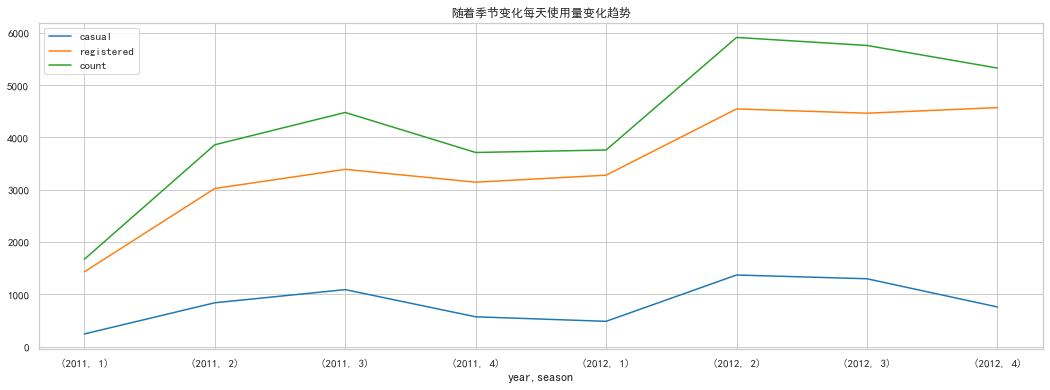

In [164]:
day_df=n_Bike_data.groupby('date').agg({'year':'mean','season':'mean',
                                      'casual':'sum', 'registered':'sum'
                                      ,'count':'sum','temp':'mean',
                                      'atemp':'mean'})

season_df = day_df.groupby(['year','season'], as_index=True).agg({'casual':'mean', 
                                                                  'registered':'mean',
                                                                  'count':'mean'})

season_df .plot(figsize=(18,6),title = '随着季节变化每天使用量变化趋势')

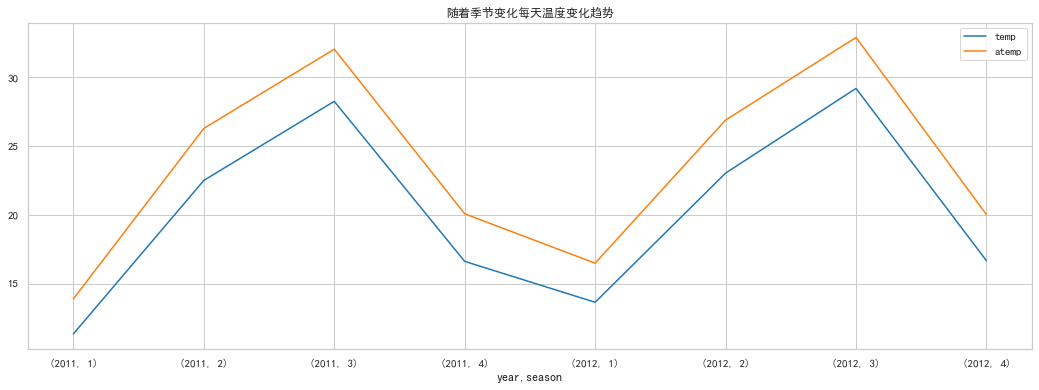

In [165]:
temp_df = day_df.groupby(['year','season'], as_index=True).agg({'temp':'mean', 
                                                                'atemp':'mean'})
temp_df.plot(figsize=(18,6),title = '随着季节变化每天温度变化趋势')

可以看出无论是临时用户还是会员用户用车的数量都在秋季迎来高峰，而春季度用户数量最低。

###### 天气情况对租赁数量的影响

不同天气的天数不同，例如非常糟糕的天气（4）会很少出现，查看一下不同天气等级的数据条数，再对租赁数量按天气等级取每小时平均值。

In [166]:
count_weather = n_Bike_data.groupby('weather')
count_weather[['casual','registered','count']].count()

,casual,registered,count
weather,,,
1,7076,7076,7076
2,2809,2809,2809
3,853,853,853
4,1,1,1


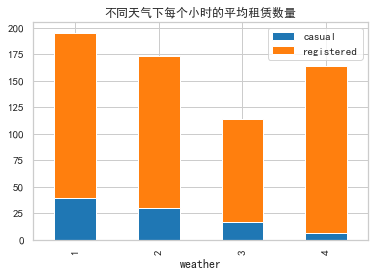

In [167]:
weather_df = n_Bike_data.groupby('weather', as_index=True).agg({'casual':'mean',
                                                              'registered':'mean'})
weather_df.plot.bar(stacked=True,title = '不同天气下每个小时的平均租赁数量')

天气等级4的时候出行人数并不少，尤其是会员出行人数甚至比天气等级2的平均值还高，按理说4等级的应该是最少的，将天气等级4的数据打印出来找一下原因：

In [168]:
n_Bike_data[Bike_data['weather']==4]

<ipython-input-168-d0cffa779ca9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_Bike_data[Bike_data['weather']==4]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,windspeed_rfr,year,month,date,hour,weekday
4921,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,6.0032,2012,1,2012-01-09,18,0


观察可知该数据是在下班高峰期产生的，所以该数据是个异常数据。不具有代表性。

###### 风速对租赁情况的影响

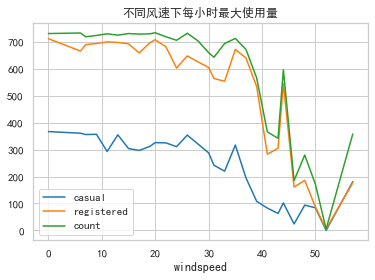

In [169]:

windspeed_rentals = n_Bike_data.groupby(['windspeed'], as_index=True).agg({'casual':'max', 
                                                                         'registered':'max',
                                                                         'count':'max'})
windspeed_rentals .plot(title = '不同风速下每小时最大使用量')

可以看到租赁数量随风速越大租赁数量越少，在风速超过30的时候明显减少，但风速在风速40左右却有一次反弹，按常理来说风速大的话骑单车比较费劲，所以单车租赁数量也会减少，可以看下反弹原因

In [170]:
df2=n_Bike_data[Bike_data['windspeed']>40]
df2=df2[df2['count']>400]
df2

<ipython-input-170-ee97302190bd>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2=n_Bike_data[Bike_data['windspeed']>40]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,windspeed_rfr,year,month,date,hour,weekday
5721,2012-03-08 17:00:00,1,0,1,1,25.42,31.06,38,43.9989,52,545,597,43.9989,2012,3,2012-03-08,17,3


可以发现这个时候时间在下班高峰期，是个异常值，不具有代表性。

###### 日期对租赁数量的影响

考虑到相同日期是否工作日，星期几，以及所属年份等信息是一样的，把租赁数据按天求和，其它日期类数据取平均值

In [171]:

day_df = n_Bike_data.groupby(['date'], as_index=False).agg({'casual':'sum','registered':'sum',
                                                          'count':'sum', 'workingday':'mean',
                                                          'weekday':'mean','holiday':'mean',
                                                          'year':'mean'})

工作日
由于工作日和休息日的天数差别，对工作日和非工作日租赁数量取了平均值，对一周中每天的租赁数量求和

(-1.4377319141150902,
 1.4303681863864328,
 -1.4388719698975816,
 1.4372896976042702)

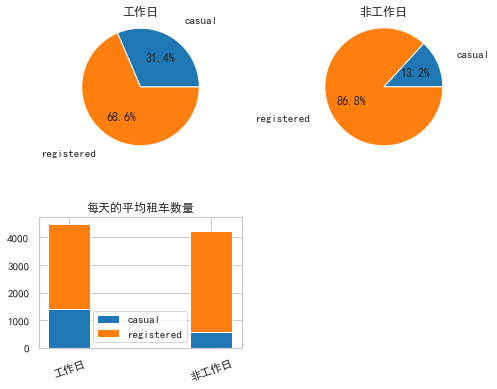

In [172]:
workingday_df=day_df.groupby(['workingday'], as_index=True).agg({'casual':'mean', 
                                                                 'registered':'mean'})
workingday_df_0 = workingday_df.loc[0]
workingday_df_1 = workingday_df.loc[1]

# plt.axes(aspect='equal')
fig = plt.figure(figsize=(8,6)) 
plt.subplots_adjust(hspace=0.5, wspace=0.2)     #设置子图表间隔
grid = plt.GridSpec(2, 2, wspace=0.5, hspace=0.5)   #设置子图表坐标轴 对齐

plt.subplot2grid((2,2),(1,0), rowspan=2)
width = 0.3       # 设置条宽

p1 = plt.bar(workingday_df.index,workingday_df['casual'], width)
p2 = plt.bar(workingday_df.index,workingday_df['registered'], 
             width,bottom=workingday_df['casual'])
plt.title('每天的平均租车数量')
plt.xticks([0,1], ('工作日', '非工作日'),rotation=20)
plt.legend((p1[0], p2[0]), ('casual', 'registered'))

plt.subplot2grid((2,2),(0,0))
plt.pie(workingday_df_0, labels=['casual','registered'], autopct='%1.1f%%', 
        pctdistance=0.6 , labeldistance=1.35 , radius=1.3)
plt.axis('equal') 
plt.title('工作日')

plt.subplot2grid((2,2),(0,1))
plt.pie(workingday_df_1, labels=['casual','registered'], autopct='%1.1f%%', 
        pctdistance=0.6 , labeldistance=1.35 , radius=1.3)
plt.title('非工作日')
plt.axis('equal') 

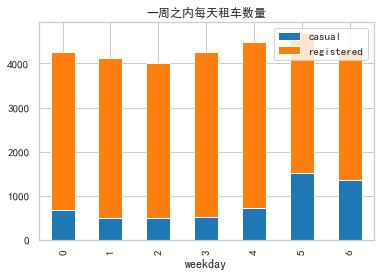

In [173]:
weekday_df= day_df.groupby(['weekday'], as_index=True).agg({'casual':'mean', 'registered':'mean'})
weekday_df.plot.bar(stacked=True , title = '一周之内每天租车数量')

对比图可发现：

1. 工作日会员用户出行数量较多，临时用户出行数量较少；
2. 周末会员用户租赁数量降低，临时用户租赁数量增加。

节假日
由于节假日在一年中数量占比非常少，先来看一每年的节假日下有几天：

In [174]:
holiday_coun=day_df.groupby('year', as_index=True).agg({'holiday':'sum'})
holiday_coun

,holiday
year,
2011,6
2012,7


假期的天数占一年天数的份额十分少，所以对假期和非假期取日平均值

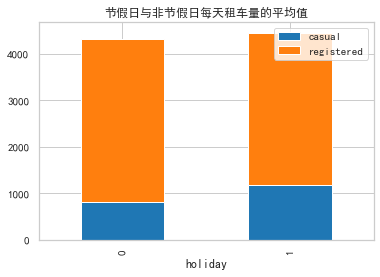

In [175]:
holiday_df = day_df.groupby('holiday',as_index=True).agg({'casual':'mean', 'registered':'mean'})
holiday_df.plot.bar(stacked=True , title = '节假日与非节假日每天租车量的平均值')

节假日会员或非会员使用量都比非节假日多，符合规律。

#### 预测性分析

##### 选择特征值

根据前面的观察，决定将时段（hour）、温度（temp）、湿度（humidity）、年份（year）、月份（month）、季节（season）、天气等级（weather）、风速（windspeed_rfr）、星期几（weekday）、是否工作日（workingday）、是否假日（holiday），11项作为特征值。

In [176]:
Bike=n_Bike_data[['year','month','hour','weekday','workingday','holiday','temp','humidity',
                 'season','weather','windspeed_rfr','count']]
Bike


,year,month,hour,weekday,workingday,holiday,temp,humidity,season,weather,windspeed_rfr,count
0,2011,1,5,5,0,0,9.84,75,1,2,6.003200,1
1,2011,1,10,5,0,0,15.58,76,1,1,16.997900,36
2,2011,1,11,5,0,0,14.76,81,1,1,19.001200,56
3,2011,1,12,5,0,0,17.22,77,1,1,19.001200,84
4,2011,1,13,5,0,0,18.86,72,1,2,19.999500,94
...,...,...,...,...,...,...,...,...,...,...,...,...
16360,2012,12,12,0,1,0,16.40,87,4,2,10.695380,232
16361,2012,12,15,0,1,0,17.22,88,4,2,9.949964,211
16362,2012,12,8,1,1,0,15.58,94,4,1,7.285353,662
16363,2012,12,22,1,1,0,13.94,49,4,1,12.183761,132


In [177]:
y = Bike['count']
X = Bike.drop(['count'],axis=1).select_dtypes(exclude=['object'])

##### 训练集验证集分离

In [178]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X.values, y.values, test_size=0.3)

In [179]:
lgb_train = lgb.Dataset(train_X, train_y)
lgb_eval = lgb.Dataset(test_X, test_y, reference=lgb_train)

##### 模型参数选择

In [180]:
#找到最优迭代次数
params = {
    'boosting_type': 'gbdt', 
    'objective': 'regression', 

    'learning_rate': 0.3, 
    'num_leaves': 50, 
    'max_depth': 17,

    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
    }
cv_results = lgb.cv(
    params, lgb_train, num_boost_round=1000, nfold=5, stratified=False, metrics='rmse',
    early_stopping_rounds=50, verbose_eval=50,  seed=0)

print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', cv_results['rmse-mean'][-1])

[50]	cv_agg's rmse: 40.051 + 1.764
[100]	cv_agg's rmse: 40.0624 + 1.84092
best n_estimators: 81
best cv score: 39.94778863665023


In [182]:
#找到使模型效果达到最优的学习率、最大深度、最大叶子数、建树的特征选择比例
model_lgb = lgb.LGBMRegressor(objective='regression',
                              boosting_type='gbdt', 
                              n_estimators=81, 
                              metric='rmse')

params_test1={
    'max_depth': range(10,30,5),
    'num_leaves':range(50, 170, 30),
    'learning_rate':[0.3,0.25,0.2,0.15,0.1,0.05,0.01],
     'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9],
    'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0]
    
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=4)
gsearch1.fit(train_X, train_y)



Fitting 5 folds for each of 2800 candidates, totalling 14000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   47.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 11.8min
[Parallel(n_jobs=4)]: Done 8442 tasks      | elapsed: 13.9min
[Parallel(n_jobs=4)]: Done 9792 tasks      | elapsed: 15.9min
[Parallel(n_jobs=4)]: Done 11242 tasks      | elapsed: 18.2mi

GridSearchCV(cv=5,
             estimator=LGBMRegressor(metric='rmse', n_estimators=81,
                                     objective='regression'),
             n_jobs=4,
             param_grid={'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0],
                         'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'learning_rate': [0.3, 0.25, 0.2, 0.15, 0.1, 0.05,
                                           0.01],
                         'max_depth': range(10, 30, 5),
                         'num_leaves': range(50, 170, 30)},
             scoring='neg_mean_squared_error', verbose=1)

In [183]:
#最优参数
gsearch1.best_params_

{'bagging_fraction': 0.6,
 'feature_fraction': 0.8,
 'learning_rate': 0.1,
 'max_depth': 10,
 'num_leaves': 110}

In [184]:

gsearch1.best_estimator_

LGBMRegressor(bagging_fraction=0.6, feature_fraction=0.8, max_depth=10,
              metric='rmse', n_estimators=81, num_leaves=110,
              objective='regression')

##### 训练、评估模型

In [185]:
# 参数
params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'regression',  # 目标函数
    'metric': {'mae'},  # 评估函数
    'num_leaves':110
    ,  # 叶子节点数
    'max_depth':10,
    'learning_rate': 0.1,  # 学习速率
    'feature_fraction': 0.8,  # 建树的特征选择比例
    'bagging_fraction': 0.6,  # 建树的样本采样比例
    'bagging_freq': 10,  # k 意味着每 k 次迭代执行bagging  
}
# 调用LightGBM模型，使用训练集数据进行训练（拟合）
my_model = lgb.train(params, lgb_train, num_boost_round=531, valid_sets=lgb_eval, early_stopping_rounds=200)
# 使用模型对验证集数据进行验证
predictions = my_model.predict(test_X, num_iteration=my_model.best_iteration)
# 对模型的预测结果进行评判
print("预测的均平均绝对误差是(mae): " + str(mean_absolute_error(predictions, test_y)))
print('预测的均方误差是(rmse):', mean_squared_error(predictions, test_y)**0.5)

[1]	valid_0's l1: 121.92
Training until validation scores don't improve for 200 rounds
[2]	valid_0's l1: 111.953
[3]	valid_0's l1: 102.437
[4]	valid_0's l1: 93.9101
[5]	valid_0's l1: 86.4908
[6]	valid_0's l1: 79.63
[7]	valid_0's l1: 73.7738
[8]	valid_0's l1: 68.4203
[9]	valid_0's l1: 63.6976
[10]	valid_0's l1: 59.5698
[11]	valid_0's l1: 55.8858
[12]	valid_0's l1: 52.5468
[13]	valid_0's l1: 50.9176
[14]	valid_0's l1: 48.1575
[15]	valid_0's l1: 45.7356
[16]	valid_0's l1: 43.47
[17]	valid_0's l1: 41.2828
[18]	valid_0's l1: 40.3489
[19]	valid_0's l1: 39.5581
[20]	valid_0's l1: 37.742
[21]	valid_0's l1: 36.037
[22]	valid_0's l1: 34.5553
[23]	valid_0's l1: 33.2984
[24]	valid_0's l1: 32.1909
[25]	valid_0's l1: 31.2039
[26]	valid_0's l1: 30.4154
[27]	valid_0's l1: 29.7183
[28]	valid_0's l1: 29.0971
[29]	valid_0's l1: 28.5125
[30]	valid_0's l1: 27.9305
[31]	valid_0's l1: 27.4243
[32]	valid_0's l1: 26.9453
[33]	valid_0's l1: 26.5314
[34]	valid_0's l1: 26.4032
[35]	valid_0's l1: 26.0574
[36]	vali

[315]	valid_0's l1: 23.1852
[316]	valid_0's l1: 23.1919
[317]	valid_0's l1: 23.1944
[318]	valid_0's l1: 23.2094
[319]	valid_0's l1: 23.2264
[320]	valid_0's l1: 23.2362
[321]	valid_0's l1: 23.234
[322]	valid_0's l1: 23.2283
[323]	valid_0's l1: 23.2357
[324]	valid_0's l1: 23.2516
[325]	valid_0's l1: 23.2446
[326]	valid_0's l1: 23.25
[327]	valid_0's l1: 23.2522
[328]	valid_0's l1: 23.2604
[329]	valid_0's l1: 23.268
[330]	valid_0's l1: 23.2681
[331]	valid_0's l1: 23.2689
[332]	valid_0's l1: 23.2778
[333]	valid_0's l1: 23.2774
[334]	valid_0's l1: 23.2912
[335]	valid_0's l1: 23.2926
[336]	valid_0's l1: 23.2893
Early stopping, best iteration is:
[136]	valid_0's l1: 22.8912
best n_estimators: 81
best cv score: 39.94778863665023
预测的均平均绝对误差是(mae): 22.891156345782857
预测的均方误差是(rmse): 36.03390720910212


##### 对测试集预测

In [188]:
test=Bike_data[(Bike_data['casual']==-1)&(Bike_data['registered']==-1)&(Bike_data['count']==-1)][['year','month','hour','weekday','workingday','holiday','temp','humidity',
                 'season','weather','windspeed_rfr']]
test

,year,month,hour,weekday,workingday,holiday,temp,humidity,season,weather,windspeed_rfr
9442,2011,1,0,3,1,0,10.66,56,1,1,26.002700
9443,2011,1,3,3,1,0,10.66,56,1,1,11.001400
9444,2011,1,4,3,1,0,10.66,56,1,1,11.001400
9445,2011,1,5,3,1,0,9.84,60,1,1,15.001300
9446,2011,1,6,3,1,0,9.02,60,1,1,15.001300
...,...,...,...,...,...,...,...,...,...,...,...
17227,2012,12,12,5,0,0,8.20,100,1,3,9.573772
17228,2012,12,13,5,0,0,8.20,100,1,3,9.573772
17229,2012,12,15,5,0,0,9.84,87,1,2,7.449305
17230,2012,12,23,5,0,0,10.66,60,1,2,25.859701


In [189]:
lgb_eval = lgb.Dataset(test,reference=lgb_train)
pre = my_model.predict(test, num_iteration=my_model.best_iteration)
test['pre']=pre
test

,year,month,hour,weekday,workingday,holiday,temp,humidity,season,weather,windspeed_rfr,pre
9442,2011,1,0,3,1,0,10.66,56,1,1,26.002700,23.053293
9443,2011,1,3,3,1,0,10.66,56,1,1,11.001400,4.847113
9444,2011,1,4,3,1,0,10.66,56,1,1,11.001400,4.847113
9445,2011,1,5,3,1,0,9.84,60,1,1,15.001300,15.054354
9446,2011,1,6,3,1,0,9.02,60,1,1,15.001300,34.738895
...,...,...,...,...,...,...,...,...,...,...,...,...
17227,2012,12,12,5,0,0,8.20,100,1,3,9.573772,233.956368
17228,2012,12,13,5,0,0,8.20,100,1,3,9.573772,231.238726
17229,2012,12,15,5,0,0,9.84,87,1,2,7.449305,361.671351
17230,2012,12,23,5,0,0,10.66,60,1,2,25.859701,109.042083
